In [11]:
import sys
import os

thesis_path = "/" + os.path.join(
    *os.getcwd().split(os.path.sep)[:-1])
sys.path.append(thesis_path)


In [2]:
from evaluations.performance_01 import get_per_sample_metrics
from evaluations.utils import get_correct_latex_format
metrics_df = get_per_sample_metrics()

/home/loebbert/miniconda3/envs/haystack/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
metrics_df.head()

,seed,model,checkpoint,dataset,doc_id,targets,entity_type,tp,fn,fp,error_type1,error_type2,error_type3,error_type4,error_type5
0,2,search_match_lownergaz_sent,best,lowner_dev,lowner_dev_0,0,location,0,0,0,0,0,0,0,0
1,2,search_match_lownergaz_sent,best,lowner_dev,lowner_dev_0,0,group,0,0,0,0,0,0,0,0
2,2,search_match_lownergaz_sent,best,lowner_dev,lowner_dev_0,0,corporation,0,0,0,0,0,0,0,0
3,2,search_match_lownergaz_sent,best,lowner_dev,lowner_dev_0,0,person,0,0,0,0,0,0,0,0
4,2,search_match_lownergaz_sent,best,lowner_dev,lowner_dev_0,0,creative-work,0,0,1,1,0,0,0,0


In [4]:
metrics_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30875400 entries, 0 to 30875399
Data columns (total 15 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   seed         object
 1   model        object
 2   checkpoint   object
 3   dataset      object
 4   doc_id       object
 5   targets      int64 
 6   entity_type  object
 7   tp           int64 
 8   fn           int64 
 9   fp           int64 
 10  error_type1  int64 
 11  error_type2  int64 
 12  error_type3  int64 
 13  error_type4  int64 
 14  error_type5  int64 
dtypes: int64(9), object(6)
memory usage: 3.5+ GB


In [5]:
metrics_df.describe()

,targets,tp,fn,fp,error_type1,error_type2,error_type3,error_type4,error_type5
count,3.087540e+07,3.087540e+07,3.087540e+07,3.087540e+07,3.087540e+07,3.087540e+07,3.087540e+07,3.087540e+07,3.087540e+07
mean,2.161282e-01,1.462266e-01,6.990154e-02,2.636537e-01,2.366940e-01,4.699852e-02,5.773723e-03,1.037337e-02,1.091516e-02
std,5.983969e-01,4.874700e-01,3.165672e-01,8.694029e-01,8.375496e-01,2.641294e-01,7.894163e-02,1.105230e-01,1.179668e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,1.200000e+01,1.200000e+01,1.200000e+01,2.300000e+01,2.300000e+01,1.200000e+01,7.000000e+00,7.000000e+00,1.100000e+01


# Model performance
## Micro-F1 + 5 Error Types avg+std

In [6]:
# Micro - F1
from evaluations.performance_01 import get_micro_f1_precision_recall
result = get_micro_f1_precision_recall(metrics_df, "last", "lowner_test")
result

model checkpoint      dataset         f1            \
                                                               mean       std   
4                 dict_match_gaz       last  lowner_test  28.573637  0.007001   
10           dict_match_gaz_sent       last  lowner_test  29.404060  0.045085   
16          dict_match_lownergaz       last  lowner_test  20.773579  0.019751   
22     dict_match_lownergaz_sent       last  lowner_test  21.611711  0.012736   
28               dict_match_sent       last  lowner_test  29.028146  0.009593   
34                 flair_roberta       last  lowner_test  84.064658  0.110460   
40              search_match_gaz       last  lowner_test  37.168811  0.018344   
46         search_match_gaz_sent       last  lowner_test  43.190684  0.019899   
52        search_match_lownergaz       last  lowner_test  50.239811  0.038783   
58   search_match_lownergaz_sent       last  lowner_test  59.462562  0.010283   
64             search_match_sent       last  lowner_test  37.187504  0.004034   
70                        t5_asp       last  lowner_test  85.481521  0.163211   
76                    t5_asp_gaz       last  lowner_test  86.515093  1.373751   
82               t5_asp_gaz_sent       last  lowner_test  88.478024  0.122478   
88              t5_asp_lownergaz       last  lowner_test  87.478254  2.444407   
94         t5_asp_lownergaz_sent       last  lowner_test  89.600103  0.029477   
100                  t5_asp_sent       last  lowner_test  86.724683  0.218033   

     precision               recall            
          mean       std       mean       std  
4    20.357842  0.004988  47.907707  0.011738  
10   20.949493  0.032122  49.300027  0.075591  
16   11.898689  0.011313  81.744289  0.077719  
22   12.376276  0.007294  85.159514  0.050186  
28   20.691513  0.006838  48.615305  0.016067  
34   82.972975  0.316572  85.186202  0.112832  
40   35.845302  0.017691  38.593802  0.019047  
46   43.988235  0.020266  42.421539  0.019544  
52   44.945538  0.034696  56.947876  0.043961  
58   59.281405  0.010252  59.644829  0.010315  
64   78.635446  0.008529  24.351877  0.002641  
70   86.982432  0.295482  84.031781  0.061052  
76   88.825027  0.325854  84.359655  2.830382  
82   89.540748  0.150150  87.440906  0.310630  
88   90.383760  0.077121  84.831641  4.507486  
94   90.848639  0.268918  88.386403  0.255862  
100  88.775777  0.208632  84.766828  0.357262

In [7]:
print(get_correct_latex_format(result, ["f1", "precision", "recall"], {"f1": "Micro-F1", "precision": "Precision", "recall": "Recall"}))

\begin{tabular}{llll}
\toprule
{} &     Micro-F1 &   Precision &       Recall \\
\textbf{Models                                   } &              &             &              \\
\midrule
\textbf{FLAIR\textsubscript{RoBERTa-Large}       } &   84.06 (11) &  82.97 (32) &   85.19 (11) \\
\textbf{T5-ASP                                   } &   85.48 (16) &  86.98 (30) &    84.03 (6) \\
\textbf{DictMatch\textsubscript{Gaz}             } &    28.57 (1) &   20.36 (0) &    47.91 (1) \\
\textbf{DictMatch\textsubscript{Sent}            } &    29.03 (1) &   20.69 (1) &    48.62 (2) \\
\textbf{DictMatch\textsubscript{LownerGaz}       } &    20.77 (2) &   11.90 (1) &    81.74 (8) \\
\textbf{DictMatch\textsubscript{Gaz+Sent}        } &    29.40 (5) &   20.95 (3) &    49.30 (8) \\
\textbf{DictMatch\textsubscript{LownerGaz+Sent}  } &    21.61 (1) &   12.38 (1) &    85.16 (5) \\
\textbf{SearchMatch\textsubscript{Gaz}           } &    37.17 (2) &   35.85 (2) &    38.59 (2) \\
\textbf{SearchMatch\textsubs

/Users/robinloebbert/Masterarbeit/thesis/evaluations/utils.py:116: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return result_df.to_latex(bold_rows=True, escape=False)


In [4]:
from evaluations.performance_01 import get_recall

get_recall(metrics_df, "last", "lowner_test").sort_values(("recall", "mean"),
                                                          ascending=False)


model checkpoint      dataset     recall          
                                                            mean       std
52      t5_asp_lownergaz_sent       last  lowner_test  88.386403  0.255862
40            t5_asp_gaz_sent       last  lowner_test  87.440906  0.310630
22              flair_roberta       last  lowner_test  85.186202  0.112832
46           t5_asp_lownergaz       last  lowner_test  84.831641  4.507486
58                t5_asp_sent       last  lowner_test  84.766828  0.357262
34                 t5_asp_gaz       last  lowner_test  84.359655  2.830382
28                     t5_asp       last  lowner_test  84.031781  0.061052
16            dict_match_sent       last  lowner_test   2.652728  0.018490
10  dict_match_lownergaz_sent       last  lowner_test   1.874981  0.026709
4        dict_match_lownergaz       last  lowner_test   1.804831  0.030775

In [3]:
# 5 Error types
from evaluations.performance_01 import get_error_types
error_result = get_error_types(metrics_df, "last", "lowner_test")
print(get_correct_latex_format(error_result, [
    "error_type1",
    "error_type2",
    "error_type3",
    "error_type4",
    "error_type5",
    "sum"
                                              ], {
    "error_type1": "Type-1",
    "error_type2": "Type-2",
    "error_type3": "Type-3",
    "error_type4": "Type-4",
    "error_type5": "Type-5",
    "sum": "Sum"
                                              }))

\begin{tabular}{lllllll}
\toprule
{} &            Type-1 &             Type-2 &           Type-3 &           Type-4 &           Type-5 &                Sum \\
\textbf{Models                                   } &                   &                    &                  &                  &                  &                    \\
\midrule
\textbf{FLAIR\textsubscript{RoBERTa-Large}       } &  2,933.67 (10335) &   2,118.00 (11268) &  1,527.00 (2563) &    683.00 (2685) &  2,550.67 (3317) &    9,812.33 (8082) \\
\textbf{T5-ASP                                   } &   1,652.67 (7151) &    3,078.00 (6031) &   1,595.00 (458) &    492.00 (1637) &  1,840.67 (5652) &   8,658.33 (10433) \\
\textbf{DictMatch\textsubscript{Gaz}             } &     68,177.00 (0) &      11,740.00 (0) &   1,802.67 (513) &  7,315.67 (1804) &  4,639.33 (1804) &    93,674.67 (513) \\
\textbf{DictMatch\textsubscript{Sent}            } &     68,148.00 (0) &      11,926.00 (0) &   1,149.33 (702) &  7,287.00 (1873) &  4,877.0

/Users/robinloebbert/Masterarbeit/thesis/evaluations/utils.py:116: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return result_df.to_latex(bold_rows=True, escape=False)


## Macro F1 + errors by entity type

In [8]:
from evaluations.performance_01 import get_f1_per_entity

entity_results = get_f1_per_entity(metrics_df, "last", "lowner_test")


In [9]:
print(get_correct_latex_format(entity_results.swaplevel(1, 2, axis=1), ["corporation", "creative-work", "group", "location", "person", "product"], {"f1": "Micro-F1"}))

\begin{tabular}{lllllll}
\toprule
{} &       Person &    Location &        Group &  Corporation & Creative Work &      Product \\
\textbf{Models                                   } &              &             &              &              &               &              \\
\midrule
\textbf{FLAIR\textsubscript{RoBERTa-Large}       } &   91.64 (26) &  89.35 (10) &   78.79 (17) &   70.74 (43) &     67.00 (6) &   50.64 (97) \\
\textbf{T5-ASP                                   } &    94.28 (3) &  87.93 (27) &   79.99 (17) &   75.11 (46) &    71.65 (10) &   44.78 (52) \\
\textbf{DictMatch\textsubscript{Gaz}             } &    44.63 (8) &   42.66 (8) &    35.73 (3) &    32.69 (8) &      8.59 (3) &   15.58 (10) \\
\textbf{DictMatch\textsubscript{Sent}            } &    43.49 (8) &   44.13 (7) &    36.67 (8) &   33.02 (10) &      8.49 (3) &    15.52 (1) \\
\textbf{DictMatch\textsubscript{LownerGaz}       } &    50.06 (8) &   25.55 (8) &   26.29 (10) &   33.65 (18) &      5.54 (0) &   15.90 (22) 

/Users/robinloebbert/Masterarbeit/thesis/evaluations/utils.py:116: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return result_df.to_latex(bold_rows=True, escape=False)


In [3]:
from evaluations.performance_01 import get_error_types_per_entity

get_error_types_per_entity(metrics_df, "last", "lowner_test").flatten

entity_type                  model checkpoint      dataset corporation  \
                                                                  mean   
                                                           error_type1   
4                           t5_asp       last  lowner_test   75.333333   
10                      t5_asp_gaz       last  lowner_test   98.666667   
16                 t5_asp_gaz_sent       last  lowner_test   88.666667   
22                t5_asp_lownergaz       last  lowner_test   81.000000   
28           t5_asp_lownergaz_sent       last  lowner_test   87.000000   
34                     t5_asp_sent       last  lowner_test   76.000000   

entity_type             creative-work                   group              \
                    std          mean         std        mean         std   
            error_type1   error_type1 error_type1 error_type1 error_type1   
4              4.725816    415.000000   15.132746  233.000000    8.660254   
10             4.163332    414.333333    4.041452  205.333333   25.501634   
16             6.658328    458.000000   24.515301  208.666667    9.237604   
22             7.211103    377.666667   53.425961  185.666667   21.594752   
28             2.645751    385.333333   15.567059  186.666667   23.158872   
34             3.464102    396.666667   30.353473  191.333333   20.599353   

entity_type    location  ... creative-work                   group  \
                   mean  ...          mean         std        mean   
            error_type1  ...   error_type5 error_type5 error_type5   
4            375.666667  ...    326.666667   11.676187  304.333333   
10           356.666667  ...    258.666667   10.016653  258.666667   
16           387.000000  ...    273.666667   18.770544  243.666667   
22           359.000000  ...    198.000000   13.453624  211.333333   
28           369.666667  ...    182.333333   16.921387  200.000000   
34           315.333333  ...    269.000000   10.000000  277.666667   

entity_type                location                  person              \
                    std        mean         std        mean         std   
            error_type5 error_type5 error_type5 error_type5 error_type5   
4              8.020806  937.000000   45.574115  173.666667    2.886751   
10            22.479620  892.333333   28.746014  172.333333    8.082904   
16             4.163332  843.000000    2.000000  166.666667   14.011900   
22            12.858201  700.333333   17.616280  128.000000    7.810250   
28             5.291503  682.333333   11.930353  129.000000    7.549834   
34             5.131601  855.666667   18.475209  169.000000    8.544004   

entity_type     product              
                   mean         std  
            error_type5 error_type5  
4             43.000000    5.000000  
10            28.000000    4.000000  
16            31.333333    0.577350  
22            31.666667    0.577350  
28            32.666667    5.859465  
34            32.333333    2.081666  

[6 rows x 63 columns]

## EECR + ECR for labeled data + search results

In [2]:
# EECR - labeled data
from evaluations.performance_01 import get_labeled_data_entity_coverage

labeled_data_eecr_df = get_labeled_data_entity_coverage()
labeled_data_eecr_df.sort_values("eecr", ascending=False)


,model,dataset,eecr,ρ=1,"ρ ∈ (0.5,1)","ρ ∈ (0,0.5]",ρ=0∧C≠0,ρ=0∧C=0
7,t5_asp_lownergaz_sent,lowner_dev,0.871725,2953,359,141,43,317
6,t5_asp_lownergaz_sent,lowner_train,0.871400,10760,949,545,140,1161
8,t5_asp_lownergaz_sent,lowner_test,0.869790,24448,1765,1180,339,2807
0,t5_asp_lownergaz,lowner_train,0.838219,10742,611,862,157,1183
2,t5_asp_lownergaz,lowner_test,0.834924,24403,1119,1790,360,2867
1,t5_asp_lownergaz,lowner_dev,0.832973,2947,215,280,46,325
14,t5_asp_sent,lowner_test,0.487843,10346,350,211,391,19241
11,t5_asp_gaz_sent,lowner_test,0.486827,10346,349,212,391,19241
12,t5_asp_sent,lowner_train,0.484656,5060,223,106,174,7992
13,t5_asp_sent,lowner_dev,0.484016,1565,79,38,44,2087


In [4]:
# EECR - labeled data - per sample eecr
from evaluations.performance_01 import get_labeled_data_entity_coverage_per_sample, aggregate_per_sample_eecr_metrics
from evaluations.utils import get_correct_latex_format

labeled_data_eecr_sample_df = get_labeled_data_entity_coverage_per_sample()
agg_labeled_data_eecr_sample_df = aggregate_per_sample_eecr_metrics(labeled_data_eecr_sample_df)
print(get_correct_latex_format(agg_labeled_data_eecr_sample_df[agg_labeled_data_eecr_sample_df["dataset"]=="lowner_test"], ["eecr"], {"eecr": "EECR"}, 4))

\begin{tabular}{ll}
\toprule
{} &           EECR \\
\textbf{Models                              } &                \\
\midrule
\textbf{T5-ASP\textsubscript{Gaz}           } &  0.3852 (4431) \\
\textbf{T5-ASP\textsubscript{Sent}          } &  0.3968 (4513) \\
\textbf{T5-ASP\textsubscript{LownerGaz}     } &  0.7056 (4105) \\
\textbf{T5-ASP\textsubscript{Gaz+Sent}      } &  0.3960 (4504) \\
\textbf{T5-ASP\textsubscript{LownerGaz+Sent}} &  0.7330 (4083) \\
\bottomrule
\end{tabular}



/Users/robinloebbert/Masterarbeit/thesis/evaluations/utils.py:116: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return result_df.to_latex(bold_rows=True, escape=False)


In [4]:
# EECR - search results - per sample eecr
from evaluations.performance_01 import get_search_results_entity_coverage_per_sample, aggregate_per_sample_eecr_metrics

search_results_data_eecr = get_search_results_entity_coverage_per_sample()
agg_search_results_data_eecr = aggregate_per_sample_eecr_metrics(search_results_data_eecr)
print(get_correct_latex_format(agg_search_results_data_eecr[agg_search_results_data_eecr["dataset"]=="lowner_test"], ["eecr"], {"eecr": "EECR"}, 4))

\begin{tabular}{ll}
\toprule
{} &           EECR \\
\textbf{Models                              } &                \\
\midrule
\textbf{T5-ASP\textsubscript{Gaz}           } &  0.3219 (4275) \\
\textbf{T5-ASP\textsubscript{Sent}          } &  0.2045 (3748) \\
\textbf{T5-ASP\textsubscript{LownerGaz}     } &  0.5188 (4633) \\
\textbf{T5-ASP\textsubscript{Gaz+Sent}      } &  0.3334 (4319) \\
\textbf{T5-ASP\textsubscript{LownerGaz+Sent}} &  0.5371 (4595) \\
\bottomrule
\end{tabular}



/Users/robinloebbert/Masterarbeit/thesis/evaluations/utils.py:104: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return result_df.to_latex(bold_rows=True, escape=False)


In [7]:
from evaluations.utils import get_correct_latex_format
from evaluations.performance_01 import get_entity_coverages

test_eecr_table = get_entity_coverages("lowner_test")

print(get_correct_latex_format(test_eecr_table, ["eecr_labeled_data", "eecr_labeled_data_per_sample", "eecr_search_results"], {"eecr_labeled_data": "EECR labeled data", "eecr_labeled_data_per_sample": "EECR labeled data per sample", "eecr_search_results": "EECR search results per sample"}))

\begin{tabular}{llll}
\toprule
{} & EECR labeled data & EECR labeled data per sample & EECR search results per sample \\
\textbf{Models                              } &                   &                              &                                \\
\midrule
\textbf{T5-ASP\textsubscript{Gaz}           } &            0.4730 &                       0.3852 &                         0.3219 \\
\textbf{T5-ASP\textsubscript{Sent}          } &            0.4878 &                       0.3968 &                         0.2045 \\
\textbf{T5-ASP\textsubscript{LownerGaz}     } &            0.8349 &                       0.7056 &                         0.5188 \\
\textbf{T5-ASP\textsubscript{Gaz+Sent}      } &            0.4868 &                       0.3960 &                         0.3334 \\
\textbf{T5-ASP\textsubscript{LownerGaz+Sent}} &            0.8698 &                       0.7330 &                         0.5371 \\
\bottomrule
\end{tabular}



/Users/robinloebbert/Masterarbeit/thesis/evaluations/utils.py:90: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return result_df.to_latex(bold_rows=True, escape=False)


## ECR - bar charts

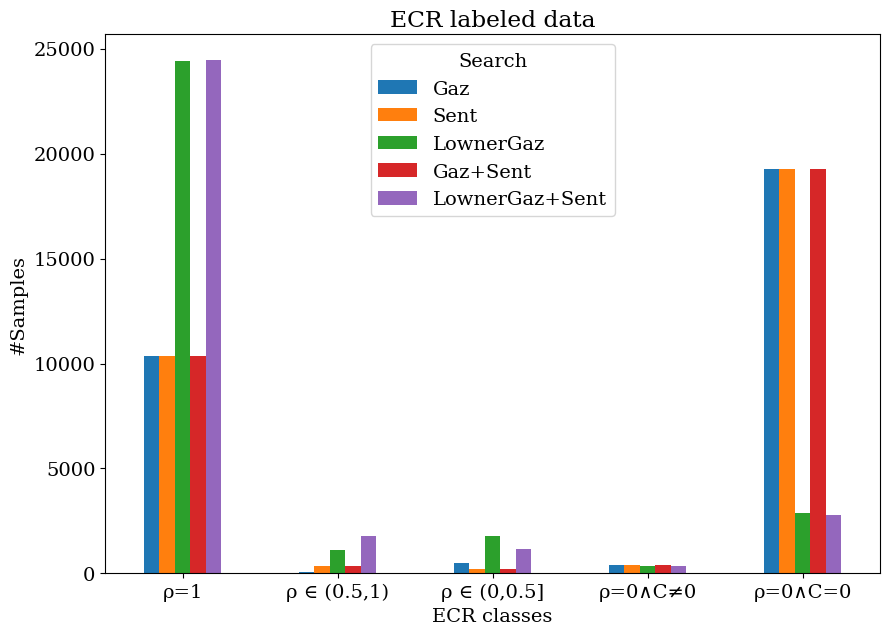

In [3]:
# ECR - labeled data - 5 classes
from evaluations.performance_01 import get_labeled_data_entity_coverage, get_ecr_plotable_table
import matplotlib.pyplot as plt

# plt.rcParams.update({
#     'mathtext.default': 'regular',
#     "mathtext.fontset":"cm",
#     "font.family": "serif",
#     "font.size": 14
# })

labeled_data_ecr_df = get_labeled_data_entity_coverage()
LATEX_THESIS_PATH = "/home/loebbert/OneDrive/Studium/Master/Masterarbeit/Thesis"

get_ecr_plotable_table(labeled_data_ecr_df, "lowner_test").plot(kind="bar", figsize=(10, 7), title="ECR labeled data", ylabel="#Samples", xlabel="ECR classes", rot=0.0)
plt.savefig(os.path.join(LATEX_THESIS_PATH, "drawings", "01_performance", "ecr_labeled_data.png"), dpi=300, bbox_inches='tight')

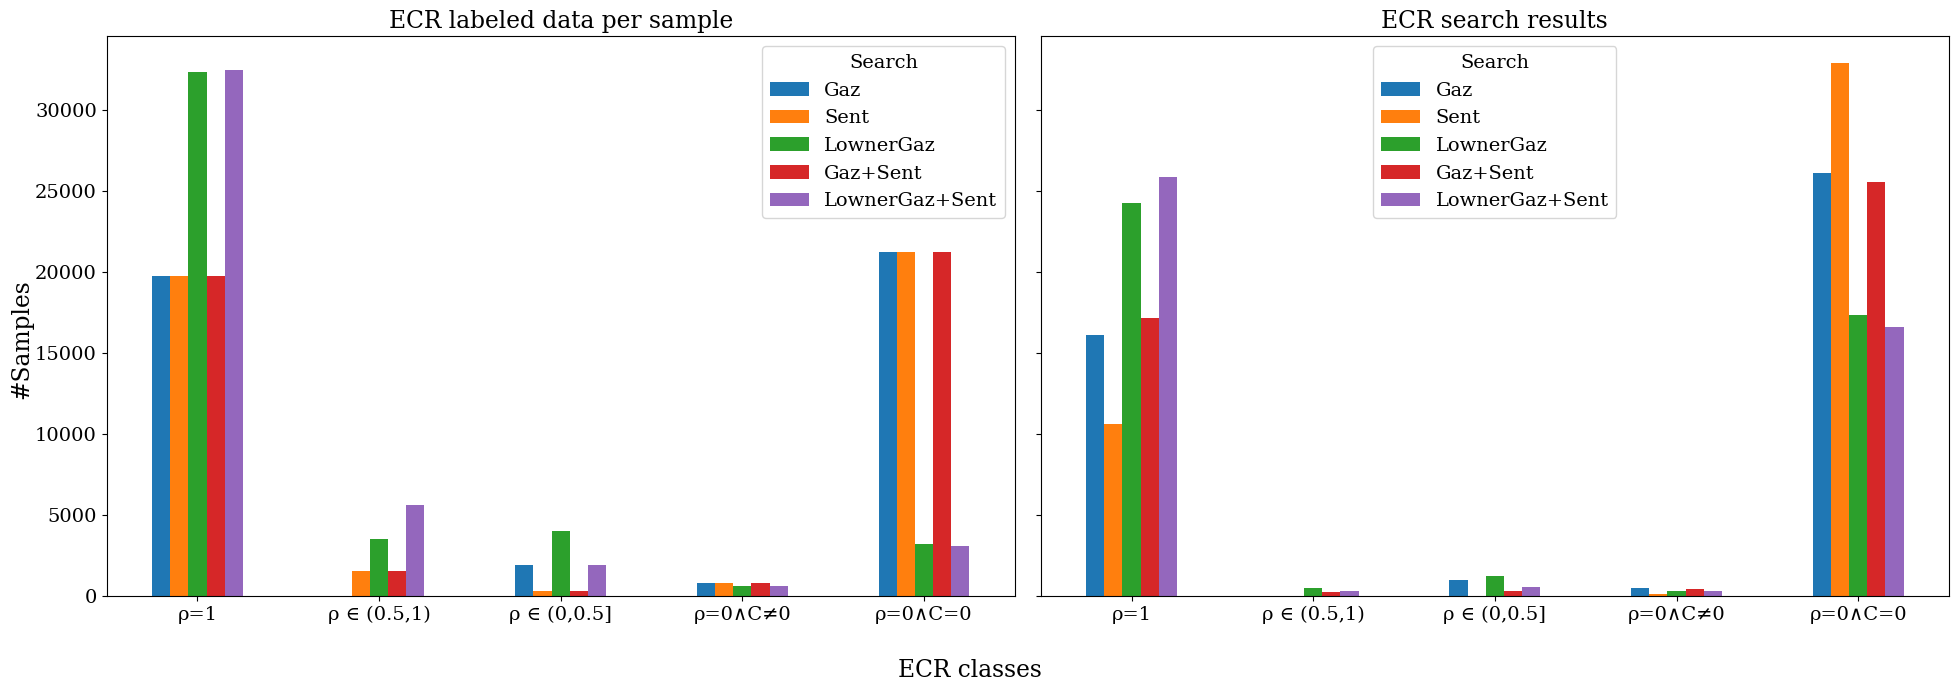

In [79]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(20,7))
fig.supylabel("#Samples")
fig.supxlabel("ECR classes")
from evaluations.performance_01 import aggregate_per_sample_ecr_classes, get_labeled_data_entity_coverage_per_sample, get_ecr_plotable_table

labeled_data_ecr_sample_df = get_labeled_data_entity_coverage_per_sample()
agg_labeled_data_ecr_sample_df = aggregate_per_sample_ecr_classes(labeled_data_ecr_sample_df)

get_ecr_plotable_table(agg_labeled_data_ecr_sample_df, "lowner_test").plot(kind="bar", ax=axs[0], title="ECR labeled data per sample", rot=0)
#plt.savefig(os.path.join(LATEX_THESIS_PATH, "drawings", "01_performance", "ecr_labeled_data_per_sample.png"), dpi=300)
from evaluations.performance_01 import get_search_results_entity_coverage_per_sample, aggregate_per_sample_ecr_classes

search_results_data_ecr = get_search_results_entity_coverage_per_sample()
agg_search_results_data_ecr = aggregate_per_sample_ecr_classes(search_results_data_ecr)

get_ecr_plotable_table(agg_search_results_data_ecr, "lowner_test").plot(kind="bar", ax=axs[1], title="ECR search results", rot=0)
plt.tight_layout()
plt.savefig(os.path.join(LATEX_THESIS_PATH, "drawings", "01_performance", "ecr_per_sample.png"), dpi=300, bbox_inches='tight')

## Context Coverage Ratio

In [29]:
# CCR search results

from evaluations.performance_01 import get_search_results_data_ccr_metrics

df = get_search_results_data_ccr_metrics()
df["score"] = df["total entities"] * df["search score"]
df["entity score"] = df["total entities"] * df["score"]
df.head()

,model,dataset,doc_id,total entities,search score,max,"φ ∈ (0.5,1]","φ ∈ (0,0.5]","φ ∈ (-0.5,0]","φ ∈ [-1,-0.5]",score,entity score
0,t5_asp_lownergaz,lowner_test,lowner_test_0,12,0.164898,0.444935,0,12,0,0,1.978779,23.745347
1,t5_asp_lownergaz,lowner_test,lowner_test_1,12,0.192069,0.639595,1,11,0,0,2.304824,27.657884
2,t5_asp_lownergaz,lowner_test,lowner_test_2,12,0.244841,0.318542,0,12,0,0,2.938096,35.257153
3,t5_asp_lownergaz,lowner_test,lowner_test_3,12,0.086775,0.376024,0,11,1,0,1.041297,12.495570
4,t5_asp_lownergaz,lowner_test,lowner_test_4,12,0.151975,0.346099,0,12,0,0,1.823706,21.884467


In [30]:
agg_df = df.pivot_table(values=["total entities", "score", "max", "entity score"], index=["model", "dataset"], aggfunc=["mean", "std"])

In [31]:
agg_df = agg_df.sort_index(axis=1, level=1).swaplevel(0, 1, axis=1).reset_index()
agg_df

model       dataset entity score                  max  \
                                                mean        std      mean   
0              t5_asp_gaz    lowner_dev    29.393014  16.139468  0.420403   
1              t5_asp_gaz   lowner_test    29.192221  15.949046  0.420175   
2              t5_asp_gaz  lowner_train    29.008637  15.866182  0.419051   
3         t5_asp_gaz_sent    lowner_dev    49.174463  53.393152  0.629744   
4         t5_asp_gaz_sent   lowner_test    49.225194  53.300556  0.630119   
5         t5_asp_gaz_sent  lowner_train    49.230722  51.372391  0.629078   
6        t5_asp_lownergaz    lowner_dev    37.548190  20.090790  0.467578   
7        t5_asp_lownergaz   lowner_test    37.603609  19.898646  0.468299   
8        t5_asp_lownergaz  lowner_train    37.350981  19.840839  0.465307   
9   t5_asp_lownergaz_sent    lowner_dev    51.581367  53.435040  0.639802   
10  t5_asp_lownergaz_sent   lowner_test    51.782107  53.564177  0.639273   
11  t5_asp_lownergaz_sent  lowner_train    51.757315  51.773669  0.637648   
12            t5_asp_sent    lowner_dev    53.780845  75.631077  0.626621   
13            t5_asp_sent   lowner_test    55.154603  84.435647  0.626859   
14            t5_asp_sent  lowner_train    55.583070  84.191704  0.625997   

                 score           total entities            
         std      mean       std           mean       std  
0   0.147701  2.450596  1.344210      11.985146  0.360476  
1   0.148764  2.433529  1.328628      11.985295  0.379343  
2   0.148896  2.418261  1.322005      11.988229  0.334093  
3   0.117333  4.466744  2.165394       9.832442  2.698935  
4   0.119587  4.462004  2.192157       9.836339  2.707055  
5   0.119529  4.461907  2.178241       9.847799  2.702726  
6   0.165765  3.129016  1.674233      11.996435  0.206835  
7   0.163981  3.133880  1.658111      11.995484  0.217431  
8   0.163835  3.112701  1.653323      11.998436  0.111534  
9   0.117645  4.715671  2.178586       9.833333  2.699595  
10  0.119954  4.725626  2.210299       9.836517  2.705507  
11  0.119786  4.719591  2.201946       9.848618  2.702979  
12  0.117516  5.113561  2.715355       8.719846  3.641955  
13  0.119601  5.143407  2.860364       8.762901  3.787111  
14  0.119464  5.155388  2.880487       8.788572  3.826185

In [32]:
agg_df[agg_df["dataset"]=="lowner_test"]

model      dataset entity score                  max  \
                                               mean        std      mean   
1              t5_asp_gaz  lowner_test    29.192221  15.949046  0.420175   
4         t5_asp_gaz_sent  lowner_test    49.225194  53.300556  0.630119   
7        t5_asp_lownergaz  lowner_test    37.603609  19.898646  0.468299   
10  t5_asp_lownergaz_sent  lowner_test    51.782107  53.564177  0.639273   
13            t5_asp_sent  lowner_test    55.154603  84.435647  0.626859   

                 score           total entities            
         std      mean       std           mean       std  
1   0.148764  2.433529  1.328628      11.985295  0.379343  
4   0.119587  4.462004  2.192157       9.836339  2.707055  
7   0.163981  3.133880  1.658111      11.995484  0.217431  
10  0.119954  4.725626  2.210299       9.836517  2.705507  
13  0.119601  5.143407  2.860364       8.762901  3.787111

In [27]:
from evaluations.utils import get_correct_latex_format

print(get_correct_latex_format(agg_df[agg_df["dataset"]=="lowner_test"], ["max", "score", "total entities"], {"max": "Top-1 Cosine Similarity", "score": "Search score", "total entities": "Entity count"}))

\begin{tabular}{llll}
\toprule
{} & Top-1 Cosine Similarity &       Score & Entity count \\
\textbf{Models                              } &                         &             &              \\
\midrule
\textbf{T5-ASP\textsubscript{Gaz}           } &               0.42 (15) &  2.43 (133) &   11.99 (38) \\
\textbf{T5-ASP\textsubscript{Sent}          } &               0.63 (12) &  5.14 (286) &   8.76 (379) \\
\textbf{T5-ASP\textsubscript{LownerGaz}     } &               0.47 (16) &  3.13 (166) &   12.00 (22) \\
\textbf{T5-ASP\textsubscript{Gaz+Sent}      } &               0.63 (12) &  4.46 (219) &   9.84 (271) \\
\textbf{T5-ASP\textsubscript{LownerGaz+Sent}} &               0.64 (12) &  4.73 (221) &   9.84 (271) \\
\bottomrule
\end{tabular}



/Users/robinloebbert/Masterarbeit/thesis/evaluations/utils.py:105: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return result_df.to_latex(bold_rows=True, escape=False)


In [8]:
df[df["model"] == "t5_asp_sent"]

,model,dataset,doc_id,total entities,search score,max,"φ ∈ (0.5,1]","φ ∈ (0,0.5]","φ ∈ (-0.5,0]","φ ∈ [-1,-0.5]",score
201800,t5_asp_sent,lowner_test,lowner_test_0,7,0.419587,0.476611,0,6,0,0,2.937111
201801,t5_asp_sent,lowner_test,lowner_test_1,7,0.534756,0.561976,6,0,0,0,3.743293
201802,t5_asp_sent,lowner_test,lowner_test_2,11,0.502550,0.532368,3,3,0,0,5.528047
201803,t5_asp_sent,lowner_test,lowner_test_3,9,0.455447,0.487919,0,6,0,0,4.099022
201804,t5_asp_sent,lowner_test,lowner_test_4,7,0.611039,0.625397,6,0,0,0,4.277272
...,...,...,...,...,...,...,...,...,...,...,...
252245,t5_asp_sent,lowner_dev,lowner_dev_3361,6,0.479686,0.499372,0,6,0,0,2.878114
252246,t5_asp_sent,lowner_dev,lowner_dev_3362,9,0.509035,0.594135,3,3,0,0,4.581311
252247,t5_asp_sent,lowner_dev,lowner_dev_3363,6,0.797964,0.834946,6,0,0,0,4.787785
252248,t5_asp_sent,lowner_dev,lowner_dev_3364,13,0.884568,0.895136,6,0,0,0,11.499381


In [10]:
from evaluations.performance_01 import get_search_results_data_ccr_max

max_ccr_search_df = get_search_results_data_ccr_max()
max_ccr_search_df[max_ccr_search_df["dataset"]=="lowner_test"].sort_values(("mean", "max"), ascending=False)

,model,dataset,mean,std
,,,max,max
10,t5_asp_lownergaz_sent,lowner_test,0.639273,0.119954
4,t5_asp_gaz_sent,lowner_test,0.630119,0.119587
13,t5_asp_sent,lowner_test,0.626859,0.119601
7,t5_asp_lownergaz,lowner_test,0.468299,0.163981
1,t5_asp_gaz,lowner_test,0.420175,0.148764


## Correlations -> Big table

Error rate -> performance indicator

1. (optional) EECR labeled data -> on aggregated performance indication
2. EECR per sample labeled data -> per sample performance indication
3. EECR per sample search results -> per sample performance indication
5. Max cosine similarity -> per sample performance indication
6. Search score -> per sample performance indication



In [79]:
from evaluations.performance_01 import get_per_sample_metrics, get_labeled_data_entity_coverage_per_sample, get_search_results_entity_coverage_per_sample, get_search_results_data_ccr_metrics

performance_metrics = get_per_sample_metrics()
labeled_data = get_labeled_data_entity_coverage_per_sample()
search_results_eecr = get_search_results_entity_coverage_per_sample()
search_results = get_search_results_data_ccr_metrics()



In [9]:
performance_metrics

,seed,model,checkpoint,dataset,doc_id,targets,entity_type,tp,fn,fp,error_type1,error_type2,error_type3,error_type4,error_type5
0,2,search_match_lownergaz_sent,best,lowner_dev,lowner_dev_0,0,location,0,0,0,0,0,0,0,0
1,2,search_match_lownergaz_sent,best,lowner_dev,lowner_dev_0,0,group,0,0,0,0,0,0,0,0
2,2,search_match_lownergaz_sent,best,lowner_dev,lowner_dev_0,0,corporation,0,0,0,0,0,0,0,0
3,2,search_match_lownergaz_sent,best,lowner_dev,lowner_dev_0,0,person,0,0,0,0,0,0,0,0
4,2,search_match_lownergaz_sent,best,lowner_dev,lowner_dev_0,0,creative-work,0,0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30875395,1,dict_match_gaz_sent,best,lowner_train,lowner_train_13422,0,group,0,0,0,0,0,0,0,0
30875396,1,dict_match_gaz_sent,best,lowner_train,lowner_train_13422,0,corporation,0,0,0,0,0,0,0,0
30875397,1,dict_match_gaz_sent,best,lowner_train,lowner_train_13422,0,person,0,0,0,0,0,0,0,0
30875398,1,dict_match_gaz_sent,best,lowner_train,lowner_train_13422,0,creative-work,0,0,1,1,0,0,0,0


In [80]:
# combine all metrics
# error rate
error_rate = performance_metrics[(performance_metrics["model"].str.startswith("t5_asp_") | performance_metrics["model"].str.startswith("search_match_") )& (performance_metrics["checkpoint"]=="last")].pivot_table(
        index=["seed", "model", "dataset", "doc_id"],
        values=["tp", "fp", "fn", "error_type1","error_type2","error_type3","error_type4","error_type5", "targets"],
        aggfunc="sum")
error_rate["error rate"] = error_rate["fp"] + error_rate["fn"]
error_rate["precision"] =  (error_rate["tp"]) / (error_rate["tp"] + error_rate["fp"] + 1e-8)
error_rate["recall"] = (error_rate["tp"]) / (error_rate["tp"] + error_rate["fn"] + 1e-8)
error_rate["f1"] = 2 * error_rate["precision"] * error_rate["recall"] / (
        error_rate["precision"] + error_rate["recall"] + 1e-8)
error_rate


error_type1  \
seed model            dataset      doc_id                           
1    search_match_gaz lowner_dev   lowner_dev_0                 2   
                                   lowner_dev_1                 0   
                                   lowner_dev_10                0   
                                   lowner_dev_100               0   
                                   lowner_dev_1000              2   
...                                                           ...   
3    t5_asp_sent      lowner_train lowner_train_9995            0   
                                   lowner_train_9996            0   
                                   lowner_train_9997            0   
                                   lowner_train_9998            0   
                                   lowner_train_9999            0   

                                                      error_type2  \
seed model            dataset      doc_id                           
1    search_match_gaz lowner_dev   lowner_dev_0                 0   
                                   lowner_dev_1                 0   
                                   lowner_dev_10                0   
                                   lowner_dev_100               0   
                                   lowner_dev_1000              0   
...                                                           ...   
3    t5_asp_sent      lowner_train lowner_train_9995            0   
                                   lowner_train_9996            0   
                                   lowner_train_9997            0   
                                   lowner_train_9998            0   
                                   lowner_train_9999            0   

                                                      error_type3  \
seed model            dataset      doc_id                           
1    search_match_gaz lowner_dev   lowner_dev_0                 0   
                                   lowner_dev_1                 0   
                                   lowner_dev_10                0   
                                   lowner_dev_100               0   
                                   lowner_dev_1000              0   
...                                                           ...   
3    t5_asp_sent      lowner_train lowner_train_9995            0   
                                   lowner_train_9996            0   
                                   lowner_train_9997            0   
                                   lowner_train_9998            0   
                                   lowner_train_9999            0   

                                                      error_type4  \
seed model            dataset      doc_id                           
1    search_match_gaz lowner_dev   lowner_dev_0                 0   
                                   lowner_dev_1                 0   
                                   lowner_dev_10                0   
                                   lowner_dev_100               0   
                                   lowner_dev_1000              0   
...                                                           ...   
3    t5_asp_sent      lowner_train lowner_train_9995            0   
                                   lowner_train_9996            0   
                                   lowner_train_9997            0   
                                   lowner_train_9998            0   
                                   lowner_train_9999            0   

                                                      error_type5  fn  fp  \
seed model            dataset      doc_id                                   
1    search_match_gaz lowner_dev   lowner_dev_0                 0   0   2   
                                   lowner_dev_1                 0   0   0   
                                   lowner_dev_10                0   0   0   
                                   lowner_dev_100               0   0   0   


In [81]:
import pandas as pd

seeds = pd.DataFrame({"seed": ["1", "2", "3"]})
eecr_labeled_data = seeds.merge(labeled_data[["model", "dataset", "doc_id", "eecr"]], how="cross").set_index(["seed", "model", "dataset", "doc_id"])
eecr_labeled_data = pd.concat([eecr_labeled_data, eecr_labeled_data.rename(index={"t5_asp_gaz": "search_match_gaz",
        "t5_asp_sent": "search_match_sent",
        "t5_asp_lownergaz": "search_match_lownergaz",
        "t5_asp_gaz_sent": "search_match_gaz_sent",
        "t5_asp_lownergaz_sent": "search_match_lownergaz_sent"})])
eecr_labeled_data

eecr
seed model             dataset      doc_id                     
1    t5_asp_lownergaz  lowner_train lowner_train_0     1.000000
                                    lowner_train_1     0.000000
                                    lowner_train_2     0.000000
                                    lowner_train_3     0.000000
                                    lowner_train_4     1.000000
...                                                         ...
3    search_match_sent lowner_test  lowner_test_33656  0.000000
                                    lowner_test_33657  1.000000
                                    lowner_test_33658  0.000000
                                    lowner_test_33659  0.500000
                                    lowner_test_33660  0.990476

[1513500 rows x 1 columns]

In [82]:
eecr_search_results = seeds.merge(search_results_eecr[["model", "dataset", "doc_id", "eecr"]], how="cross").set_index(["seed", "model", "dataset", "doc_id"])
eecr_search_results = pd.concat([eecr_search_results, eecr_search_results.rename(index={"t5_asp_gaz": "search_match_gaz",
        "t5_asp_sent": "search_match_sent",
        "t5_asp_lownergaz": "search_match_lownergaz",
        "t5_asp_gaz_sent": "search_match_gaz_sent",
        "t5_asp_lownergaz_sent": "search_match_lownergaz_sent"})])
eecr_search_results

eecr
seed model             dataset     doc_id               
1    t5_asp_lownergaz  lowner_test lowner_test_0     1.0
                                   lowner_test_1     0.0
                                   lowner_test_2     0.0
                                   lowner_test_3     1.0
                                   lowner_test_4     0.0
...                                                  ...
3    search_match_sent lowner_dev  lowner_dev_3361   0.0
                                   lowner_dev_3362   0.0
                                   lowner_dev_3363   0.0
                                   lowner_dev_3364   0.5
                                   lowner_dev_3365   0.0

[1513500 rows x 1 columns]

In [83]:
search_results_top1 = seeds.merge(search_results[["model", "dataset", "doc_id", "max"]], how="cross").set_index(["seed", "model", "dataset", "doc_id"])
search_results_top1 = pd.concat([search_results_top1, search_results_top1.rename(index={"t5_asp_gaz": "search_match_gaz",
        "t5_asp_sent": "search_match_sent",
        "t5_asp_lownergaz": "search_match_lownergaz",
        "t5_asp_gaz_sent": "search_match_gaz_sent",
        "t5_asp_lownergaz_sent": "search_match_lownergaz_sent"})])
search_results_top1

max
seed model             dataset     doc_id                   
1    t5_asp_lownergaz  lowner_test lowner_test_0    0.444935
                                   lowner_test_1    0.639595
                                   lowner_test_2    0.318542
                                   lowner_test_3    0.376024
                                   lowner_test_4    0.346099
...                                                      ...
3    search_match_sent lowner_dev  lowner_dev_3361  0.499372
                                   lowner_dev_3362  0.594135
                                   lowner_dev_3363  0.834946
                                   lowner_dev_3364  0.895136
                                   lowner_dev_3365  0.628141

[1513500 rows x 1 columns]

In [84]:
search_results["score"] = search_results["total entities"] * search_results["search score"]

In [85]:
search_results_score = seeds.merge(search_results[["model", "dataset", "doc_id", "score"]], how="cross").set_index(["seed", "model", "dataset", "doc_id"])
search_results_score = pd.concat([search_results_score, search_results_score.rename(index={"t5_asp_gaz": "search_match_gaz",
        "t5_asp_sent": "search_match_sent",
        "t5_asp_lownergaz": "search_match_lownergaz",
        "t5_asp_gaz_sent": "search_match_gaz_sent",
        "t5_asp_lownergaz_sent": "search_match_lownergaz_sent"})])
search_results_score

score
seed model             dataset     doc_id                    
1    t5_asp_lownergaz  lowner_test lowner_test_0     1.978779
                                   lowner_test_1     2.304824
                                   lowner_test_2     2.938096
                                   lowner_test_3     1.041297
                                   lowner_test_4     1.823706
...                                                       ...
3    search_match_sent lowner_dev  lowner_dev_3361   2.878114
                                   lowner_dev_3362   4.581311
                                   lowner_dev_3363   4.787785
                                   lowner_dev_3364  11.499381
                                   lowner_dev_3365   3.500583

[1513500 rows x 1 columns]

In [86]:
# combine
# error_rate
# eecr_labeled_data
# eecr_search_results
# search_results_top1
# search_results_score
combined_df = error_rate.join(eecr_labeled_data, on=["seed", "model", "dataset", "doc_id"])
combined_df = combined_df.join(eecr_search_results, on=["seed", "model", "dataset", "doc_id"], lsuffix="_labeled_data", rsuffix="_search_results")
combined_df = combined_df.join(search_results_top1, on=["seed", "model", "dataset", "doc_id"])
combined_df = combined_df.join(search_results_score, on=["seed", "model", "dataset", "doc_id"])
combined_df

error_type1  \
seed model            dataset      doc_id                           
1    search_match_gaz lowner_dev   lowner_dev_0                 2   
                                   lowner_dev_1                 0   
                                   lowner_dev_10                0   
                                   lowner_dev_100               0   
                                   lowner_dev_1000              2   
...                                                           ...   
3    t5_asp_sent      lowner_train lowner_train_9995            0   
                                   lowner_train_9996            0   
                                   lowner_train_9997            0   
                                   lowner_train_9998            0   
                                   lowner_train_9999            0   

                                                      error_type2  \
seed model            dataset      doc_id                           
1    search_match_gaz lowner_dev   lowner_dev_0                 0   
                                   lowner_dev_1                 0   
                                   lowner_dev_10                0   
                                   lowner_dev_100               0   
                                   lowner_dev_1000              0   
...                                                           ...   
3    t5_asp_sent      lowner_train lowner_train_9995            0   
                                   lowner_train_9996            0   
                                   lowner_train_9997            0   
                                   lowner_train_9998            0   
                                   lowner_train_9999            0   

                                                      error_type3  \
seed model            dataset      doc_id                           
1    search_match_gaz lowner_dev   lowner_dev_0                 0   
                                   lowner_dev_1                 0   
                                   lowner_dev_10                0   
                                   lowner_dev_100               0   
                                   lowner_dev_1000              0   
...                                                           ...   
3    t5_asp_sent      lowner_train lowner_train_9995            0   
                                   lowner_train_9996            0   
                                   lowner_train_9997            0   
                                   lowner_train_9998            0   
                                   lowner_train_9999            0   

                                                      error_type4  \
seed model            dataset      doc_id                           
1    search_match_gaz lowner_dev   lowner_dev_0                 0   
                                   lowner_dev_1                 0   
                                   lowner_dev_10                0   
                                   lowner_dev_100               0   
                                   lowner_dev_1000              0   
...                                                           ...   
3    t5_asp_sent      lowner_train lowner_train_9995            0   
                                   lowner_train_9996            0   
                                   lowner_train_9997            0   
                                   lowner_train_9998            0   
                                   lowner_train_9999            0   

                                                      error_type5  fn  fp  \
seed model            dataset      doc_id                                   
1    search_match_gaz lowner_dev   lowner_dev_0                 0   0   2   
                                   lowner_dev_1                 0   0   0   
                                   lowner_dev_10                0   0   0   
                                   lowner_dev_100               0   0   0   


In [87]:
combined_df.to_pickle(os.path.join(thesis_path, "evaluations", "metrics", "01_performance_combined_df.pkl.tar.gz"))

In [41]:
from scipy.stats import pearsonr
from typing import List
from evaluations.utils import LATEX_MODEL_NAMES


def per_sample_error_rate_pearsonr(df: pd.DataFrame,
                                   data_metrics: List[str],
                                   performance_metrics: List[str], 
                    alternative: str = "two-sided", confidence_level: float = 0.95):
    no_index_df = df.reset_index()
    models = no_index_df["model"].unique().tolist() + ["t5_asp_overall", "search_match_overall", "overall"]
    datasets = no_index_df["dataset"].unique()
    
    pearson_corrs = []
    for dataset in datasets:
        dataset_df = no_index_df[no_index_df["dataset"] == dataset]
        for model in models:
            if model == "overall":
                model_df = dataset_df
            elif model == "t5_asp_overall":
                model_df = dataset_df[dataset_df["model"].str.startswith("t5_asp_")]
            elif model == "search_match_overall":
                model_df = dataset_df[dataset_df["model"].str.startswith("search_match_")]
            else:
                model_df = dataset_df[dataset_df["model"] == model]
            for data_metric in data_metrics:
                metric_df = model_df.fillna(value=0.0)
                for perf_metric in performance_metrics:
                    corr = pearsonr(metric_df[data_metric].tolist(), metric_df[perf_metric].tolist(), alternative=alternative)
                    conf = corr.confidence_interval(confidence_level=confidence_level)
                    pearson_corrs.append({
                        "model": model,
                        "dataset": dataset,
                        "perf_metric": perf_metric,
                        "data_metric": data_metric,
                        "coefficient": corr.statistic,
                        "pvalue": corr.pvalue,
                        "conf_low": conf.low,
                        "conf_high": conf.high
                    })
                

    return pd.DataFrame.from_records(pearson_corrs)

pearson_corr_df = per_sample_error_rate_pearsonr(combined_df, ["eecr_labeled_data",	"eecr_search_results", "max", "score"], [
    "error_type1", "error_type2", "error_type3", "error_type4", "error_type5", "fn", "fp", "error rate", "tp", "precision", "recall", "f1", "targets"
])

/Users/robinloebbert/opt/miniconda3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [42]:
pearson_corr_df.to_pickle(os.path.join(thesis_path, "evaluations", "metrics", "01_performance_correlations.pkl"))

In [78]:
import pandas as pd

pearson_corr_df = pd.read_pickle(
    os.path.join(thesis_path, "evaluations", "metrics",
                 "01_performance_correlations.pkl"))


In [3]:
overall_correlations = pearson_corr_df[(pearson_corr_df["dataset"] == "lowner_test") & (pearson_corr_df["model"].str.endswith("_overall"))].pivot_table(values="coefficient", columns="data_metric", index=["perf_metric", "model"])
overall_correlations

data_metric                       eecr_labeled_data  eecr_search_results  \
perf_metric model                                                          
error rate  search_match_overall          -0.221945            -0.407157   
            t5_asp_overall                -0.044018            -0.106247   
error_type1 search_match_overall          -0.049304            -0.049132   
            t5_asp_overall                -0.007253            -0.019286   
error_type2 search_match_overall          -0.139674            -0.441278   
            t5_asp_overall                -0.003813            -0.052624   
error_type3 search_match_overall          -0.036252            -0.021658   
            t5_asp_overall                -0.046613            -0.074733   
error_type4 search_match_overall          -0.140879            -0.106695   
            t5_asp_overall                -0.025872            -0.039118   
error_type5 search_match_overall          -0.118502            -0.100804   
            t5_asp_overall                -0.024336            -0.048662   
f1          search_match_overall           0.737415             0.933108   
            t5_asp_overall                 0.435402             0.376854   
fn          search_match_overall          -0.200451            -0.479509   
            t5_asp_overall                -0.030225            -0.099447   
fp          search_match_overall          -0.117292            -0.101470   
            t5_asp_overall                -0.048344            -0.085735   
precision   search_match_overall           0.685112             0.839348   
            t5_asp_overall                 0.433858             0.372174   
recall      search_match_overall           0.758561             0.975938   
            t5_asp_overall                 0.433387             0.376286   
targets     search_match_overall           0.293900             0.162310   
            t5_asp_overall                 0.293900             0.162310   
tp          search_match_overall           0.612595             0.753535   
            t5_asp_overall                 0.307192             0.206046   

data_metric                            max     score  
perf_metric model                                     
error rate  search_match_overall -0.180969 -0.013457  
            t5_asp_overall       -0.038472  0.003018  
error_type1 search_match_overall -0.194611 -0.186794  
            t5_asp_overall       -0.008350  0.012139  
error_type2 search_match_overall -0.079742  0.141476  
            t5_asp_overall       -0.047300 -0.026579  
error_type3 search_match_overall -0.002253  0.011102  
            t5_asp_overall       -0.020171  0.010797  
error_type4 search_match_overall -0.025247 -0.006475  
            t5_asp_overall       -0.008524 -0.000588  
error_type5 search_match_overall  0.014257  0.021143  
            t5_asp_overall       -0.003359  0.009531  
f1          search_match_overall  0.330662  0.246815  
            t5_asp_overall        0.214649  0.197100  
fn          search_match_overall -0.079015  0.143661  
            t5_asp_overall       -0.045537 -0.008888  
fp          search_match_overall -0.181514 -0.165601  
            t5_asp_overall       -0.019914  0.016120  
precision   search_match_overall  0.328169  0.285554  
            t5_asp_overall        0.212812  0.196945  
recall      search_match_overall  0.305453  0.195990  
            t5_asp_overall        0.213237  0.196082  
targets     search_match_overall  0.139136  0.405262  
            t5_asp_overall        0.139136  0.405262  
tp          search_match_overall  0.272130  0.371783  
            t5_asp_overall        0.159162  0.409170

In [4]:
from evaluations.utils import get_correlations_correct_latex_format

overall_model_names = {
    "search_match_overall": "SearchMatch",
    "t5_asp_overall": "T5-ASP"
}
print(
    get_correlations_correct_latex_format(overall_correlations,
                                          overall_model_names))


\begin{tabular}{@{} ll*4{S[table-format = 1.4, group-minimum-digits=5]}@{}}
\toprule
{} & {Input Data Metric} & {EECR labeled data} & {EECR search results} & {Top-1 Cosine Similarity} & {Search score} \\
{Performance Metric} & {Model type} & {} & {} & {} & {} \\
\midrule
\multirow[t]{2}{*}{Error Type-1} & SearchMatch & -0.0493 & -0.0491 & -0.1946 & -0.1868 \\
 & T5-ASP & -0.0073 & -0.0193 & -0.0084 & 0.0121 \\
\multirow[t]{2}{*}{Error Type-2} & SearchMatch & -0.1397 & \cellcolor[HTML]{C6DBEF} -0.4413 & -0.0797 & 0.1415 \\
 & T5-ASP & -0.0038 & -0.0526 & -0.0473 & -0.0266 \\
\multirow[t]{2}{*}{Error Type-3} & SearchMatch & -0.0363 & -0.0217 & -0.0023 & 0.0111 \\
 & T5-ASP & -0.0466 & -0.0747 & -0.0202 & 0.0108 \\
\multirow[t]{2}{*}{Error Type-4} & SearchMatch & -0.1409 & -0.1067 & -0.0252 & -0.0065 \\
 & T5-ASP & -0.0259 & -0.0391 & -0.0085 & -0.0006 \\
\multirow[t]{2}{*}{Error Type-5} & SearchMatch & -0.1185 & -0.1008 & 0.0143 & 0.0211 \\
 & T5-ASP & -0.0243 & -0.0487 & -0.0034 & 0.009

In [6]:
from evaluations.utils import get_correlations_correct_latex_format

tp_corr_df = pearson_corr_df[(pearson_corr_df["dataset"] == "lowner_test") & (pearson_corr_df["perf_metric"].isin(["tp", "f1", "targets"])) & (~pearson_corr_df["model"].str.endswith("overall"))].pivot_table(values="coefficient", columns="data_metric", index=["perf_metric", "model"])

print(get_correlations_correct_latex_format(tp_corr_df))

\begin{tabular}{@{} ll*4{S[table-format = 1.4, group-minimum-digits=5]}@{}}
\toprule
{} & {Input Data Metric} & {EECR labeled data} & {EECR search results} & {Top-1 Cosine Similarity} & {Search score} \\
{Performance Metric} & {Model type} & {} & {} & {} & {} \\
\midrule
\multirow[t]{10}{*}{True positives} & SearchMatch\textsubscript{Gaz} & \cellcolor[HTML]{6BAED6} 0.6901 & \cellcolor[HTML]{2171B5} \color{white} 0.7660 & \cellcolor[HTML]{C6DBEF} 0.3653 & 0.2328 \\
 & SearchMatch\textsubscript{Sent} & \cellcolor[HTML]{6BAED6} 0.5362 & \cellcolor[HTML]{2171B5} \color{white} 0.8064 & \cellcolor[HTML]{C6DBEF} 0.3846 & \cellcolor[HTML]{C6DBEF} 0.4798 \\
 & SearchMatch\textsubscript{LownerGaz} & \cellcolor[HTML]{6BAED6} 0.5387 & \cellcolor[HTML]{2171B5} \color{white} 0.7174 & \cellcolor[HTML]{C6DBEF} 0.3930 & \cellcolor[HTML]{C6DBEF} 0.3488 \\
 & SearchMatch\textsubscript{Gaz+Sent} & \cellcolor[HTML]{6BAED6} 0.6941 & \cellcolor[HTML]{2171B5} \color{white} 0.7261 & \cellcolor[HTML]{C6DBEF} 0.

## Violin plot - Search Score <> Input Entity Count bins

In [3]:
from evaluations.performance_01 import get_per_sample_metrics, get_labeled_data_entity_coverage_per_sample, get_search_results_entity_coverage_per_sample, get_search_results_data_ccr_metrics

performance_metrics = get_per_sample_metrics()
search_results = get_search_results_data_ccr_metrics()

performance_metrics

/home/loebbert/miniconda3/envs/haystack/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,seed,model,checkpoint,dataset,doc_id,targets,entity_type,tp,fn,fp,error_type1,error_type2,error_type3,error_type4,error_type5
0,2,search_match_lownergaz_sent,best,lowner_dev,lowner_dev_0,0,location,0,0,0,0,0,0,0,0
1,2,search_match_lownergaz_sent,best,lowner_dev,lowner_dev_0,0,group,0,0,0,0,0,0,0,0
2,2,search_match_lownergaz_sent,best,lowner_dev,lowner_dev_0,0,corporation,0,0,0,0,0,0,0,0
3,2,search_match_lownergaz_sent,best,lowner_dev,lowner_dev_0,0,person,0,0,0,0,0,0,0,0
4,2,search_match_lownergaz_sent,best,lowner_dev,lowner_dev_0,0,creative-work,0,0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30875395,1,dict_match_gaz_sent,best,lowner_train,lowner_train_13422,0,group,0,0,0,0,0,0,0,0
30875396,1,dict_match_gaz_sent,best,lowner_train,lowner_train_13422,0,corporation,0,0,0,0,0,0,0,0
30875397,1,dict_match_gaz_sent,best,lowner_train,lowner_train_13422,0,person,0,0,0,0,0,0,0,0
30875398,1,dict_match_gaz_sent,best,lowner_train,lowner_train_13422,0,creative-work,0,0,1,1,0,0,0,0


In [16]:
import pandas as pd
def get_target_bin(target_count: int):
    if target_count < 3:
        return str(target_count)
    return "> 2"


df = performance_metrics.pivot_table(
    values="targets",
    index=["dataset", "doc_id", "entity_type"],
    aggfunc="mean").reset_index().pivot_table(
        values="targets",
        index=["dataset", "doc_id"],
        aggfunc="sum")
df["target bin"] = df.apply(lambda x: x.apply(get_target_bin))
models = pd.DataFrame({
    "model": [
        't5_asp_lownergaz', 't5_asp_gaz', 't5_asp_lownergaz_sent',
        't5_asp_gaz_sent', 't5_asp_sent'
    ]
})
input_entity_count_df = models.merge(df.reset_index(), how="cross").set_index(
    ["model", "dataset", "doc_id"])
input_entity_count_df


targets target bin
model            dataset      doc_id                               
t5_asp_lownergaz lowner_dev   lowner_dev_0             0          0
                              lowner_dev_1             2          2
                              lowner_dev_10            1          1
                              lowner_dev_100           1          1
                              lowner_dev_1000          2          2
...                                                  ...        ...
t5_asp_sent      lowner_train lowner_train_9995        1          1
                              lowner_train_9996        1          1
                              lowner_train_9997        1          1
                              lowner_train_9998        1          1
                              lowner_train_9999        2          2

[252250 rows x 2 columns]

In [5]:
search_results["score"] = search_results["total entities"] * search_results[
    "search score"]

In [6]:
search_results

,model,dataset,doc_id,total entities,search score,max,"φ ∈ (0.5,1]","φ ∈ (0,0.5]","φ ∈ (-0.5,0]","φ ∈ [-1,-0.5]",score
0,t5_asp_lownergaz,lowner_test,lowner_test_0,12,0.164898,0.444935,0,12,0,0,1.978779
1,t5_asp_lownergaz,lowner_test,lowner_test_1,12,0.192069,0.639595,1,11,0,0,2.304824
2,t5_asp_lownergaz,lowner_test,lowner_test_2,12,0.244841,0.318542,0,12,0,0,2.938096
3,t5_asp_lownergaz,lowner_test,lowner_test_3,12,0.086775,0.376024,0,11,1,0,1.041297
4,t5_asp_lownergaz,lowner_test,lowner_test_4,12,0.151975,0.346099,0,12,0,0,1.823706
...,...,...,...,...,...,...,...,...,...,...,...
252245,t5_asp_sent,lowner_dev,lowner_dev_3361,6,0.479686,0.499372,0,6,0,0,2.878114
252246,t5_asp_sent,lowner_dev,lowner_dev_3362,9,0.509035,0.594135,3,3,0,0,4.581311
252247,t5_asp_sent,lowner_dev,lowner_dev_3363,6,0.797964,0.834946,6,0,0,0,4.787785
252248,t5_asp_sent,lowner_dev,lowner_dev_3364,13,0.884568,0.895136,6,0,0,0,11.499381


In [7]:
search_scores = search_results[["model", "dataset", "doc_id", "score"
                                ]].set_index(["model", "dataset", "doc_id"])
search_scores

score
model            dataset     doc_id                    
t5_asp_lownergaz lowner_test lowner_test_0     1.978779
                             lowner_test_1     2.304824
                             lowner_test_2     2.938096
                             lowner_test_3     1.041297
                             lowner_test_4     1.823706
...                                                 ...
t5_asp_sent      lowner_dev  lowner_dev_3361   2.878114
                             lowner_dev_3362   4.581311
                             lowner_dev_3363   4.787785
                             lowner_dev_3364  11.499381
                             lowner_dev_3365   3.500583

[252250 rows x 1 columns]

In [34]:
comp_df = input_entity_count_df.join(search_scores)
comp_df["target bin idx"] = comp_df["targets"].apply(lambda x: x if x <=2 else 3)
comp_df.loc["t5_asp_sent","lowner_test"].describe()

/tmp/ipykernel_5669/3025036853.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  comp_df.loc["t5_asp_sent","lowner_test"].describe()


,targets,score,target bin idx
count,33661.000000,33661.000000,33661.000000
mean,1.298714,5.143407,1.234693
std,1.025310,2.860364,0.821501
min,0.000000,1.730410,0.000000
25%,1.000000,3.514901,1.000000
50%,1.000000,4.371833,1.000000
75%,2.000000,5.696232,2.000000
max,12.000000,40.866938,3.000000


/tmp/ipykernel_5669/1018251852.py:41: PerformanceWarning: indexing past lexsort depth may impact performance.
  sns.violinplot(comp_df.loc[model, "lowner_test"],
/tmp/ipykernel_5669/1018251852.py:54: PerformanceWarning: indexing past lexsort depth may impact performance.
  comp_df.loc[model, "lowner_test"]['target bin idx'],
/tmp/ipykernel_5669/1018251852.py:55: PerformanceWarning: indexing past lexsort depth may impact performance.
  comp_df.loc[model, "lowner_test"]['score'])
/tmp/ipykernel_5669/1018251852.py:41: PerformanceWarning: indexing past lexsort depth may impact performance.
  sns.violinplot(comp_df.loc[model, "lowner_test"],
/tmp/ipykernel_5669/1018251852.py:54: PerformanceWarning: indexing past lexsort depth may impact performance.
  comp_df.loc[model, "lowner_test"]['target bin idx'],
/tmp/ipykernel_5669/1018251852.py:55: PerformanceWarning: indexing past lexsort depth may impact performance.
  comp_df.loc[model, "lowner_test"]['score'])
/tmp/ipykernel_5669/1018251852.py:

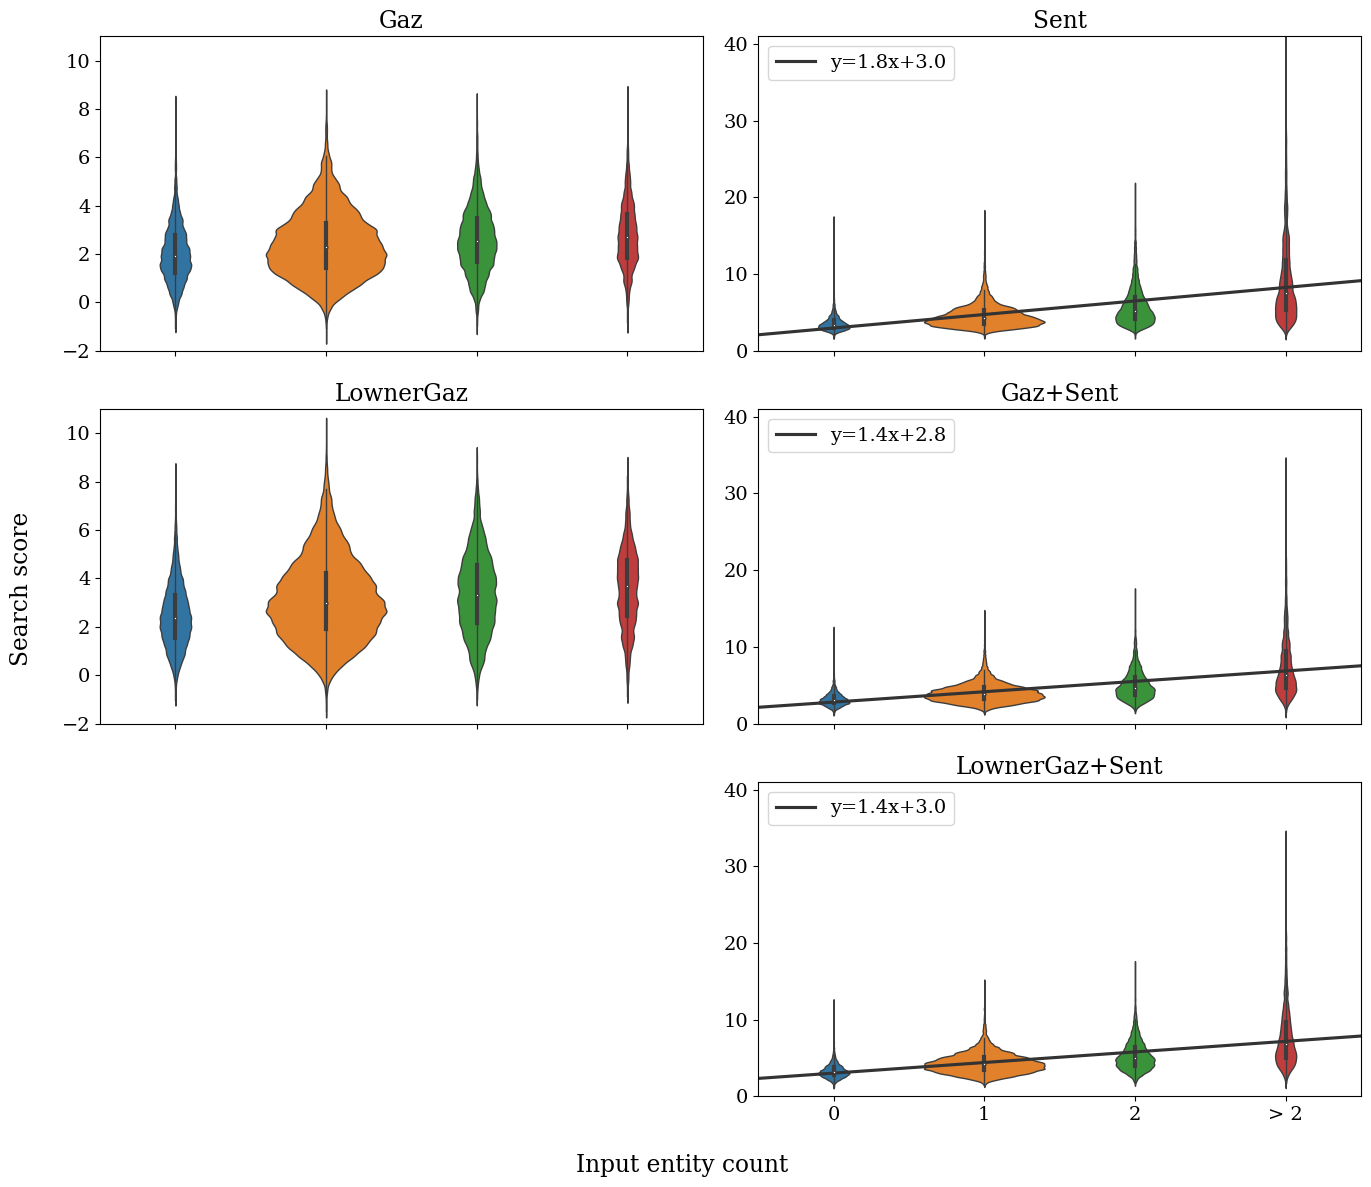

In [47]:
import seaborn as sns
from evaluations.utils import MODEL_ORDER
import matplotlib.pyplot as plt
from scipy import stats

plot_model_names = {
    "t5_asp_gaz": "Gaz",
    "t5_asp_sent": "Sent",
    "t5_asp_lownergaz": "LownerGaz",
    "t5_asp_gaz_sent": "Gaz+Sent",t5_combined_df
fig, axs = plt.subplots(3, 2, sharex=True, figsize=(14, 12))

fig.supxlabel("Input entity count")
fig.supylabel("Search score")

positions = [
    (0, 0),
    (0, 1),
    (1, 0),
    (1, 1),
    (2, 1)
]

axs[(2, 0)].axis('off')

for idx, model in enumerate(sorted(plot_model_names.keys(), key=lambda x: MODEL_ORDER.get(x, 1000))):
    is_left = positions[idx][1] == 0
    if is_left:
        ylimit = (-2, 11)
    else:
        ylimit = (0, 41)
    order = [
        "0",
        "1",
        "2",
        "> 2",
    ]
    sns.violinplot(comp_df.loc[model, "lowner_test"],
                   y="score",
                   x="target bin",
                   order=order,
                   inner="box",
                   scale="count",
                   bw=0.08,
                   linewidth=1,
                   gridsize=300,
                   split=True,
                   ax=axs[positions[idx]],
                   zorder=1)
    slope, intercept, r_value, p_value, std_err = stats.linregress(
        comp_df.loc[model, "lowner_test"]['target bin idx'],
        comp_df.loc[model, "lowner_test"]['score'])
    if r_value >= 0.3 or r_value <= -0.3:
        sns.regplot(
            comp_df.loc[model, "lowner_test"],
            y="score",
            x="target bin idx",
            #x_bins="target bin",
            order=1,
            scatter=False,
            truncate=False,
            color=".2",
            ax=axs[positions[idx]],
            label="y={0:.1f}x+{1:.1f}".format(slope, intercept))
        axs[positions[idx]].legend(loc=2)
    axs[positions[idx]].set_ylim(ylimit)
    axs[positions[idx]].set_xlabel("")

    axs[positions[idx]].set_ylabel("")
    axs[positions[idx]].set_title(plot_model_names[model])

plt.tight_layout()
LATEX_THESIS_PATH = "/home/loebbert/OneDrive/Studium/Master/Masterarbeit/Thesis"
plt.savefig(os.path.join(LATEX_THESIS_PATH, "drawings", "01_performance", "violin_corr_input_entity_search_score.png"), dpi=200)


## Hypothesis 1-3 - Linechart T5-ASP F1 per seed

In [48]:
from evaluations.performance_01 import get_per_sample_metrics, aggregate_performance_metrics

performance_metrics = get_per_sample_metrics()
agg_perf_metrics = aggregate_performance_metrics(performance_metrics)
agg_perf_metrics.loc[:, :, "last", "lowner_test"]

fn      fp     tp  precision     recall  \
seed model                                                                     
1    dict_match_gaz               22774   81934  20942  20.356546  47.904657   
     dict_match_gaz_sent          22162   81322  21554  20.951437  49.304602   
     dict_match_lownergaz          7943  264557  35773  11.911231  81.830451   
     dict_match_lownergaz_sent     6513  263601  37203  12.367854  85.101565   
     dict_match_sent              22464   81460  21252  20.690864  48.613780   
     flair_roberta                 6513    7548  37203  83.133338  85.101565   
     search_match_gaz             26851   30203  16865  35.831138  38.578552   
     search_match_gaz_sent        25163   23606  18553  44.007211  42.439839   
     search_match_lownergaz       18824   30498  24892  44.939520  56.940251   
     search_match_lownergaz_sent  17646   17914  26070  59.271553  59.634916   
     search_match_sent            33071    2893  10645  78.630521  24.350352   
     t5_asp                        6977    5354  36739  87.280545  84.040168   
     t5_asp_gaz                    6110    4887  37606  88.499282  86.023424   
     t5_asp_gaz_sent               5360    4561  38356  89.372510  87.739043   
     t5_asp_lownergaz              8906    3713  34810  90.361602  79.627596   
     t5_asp_lownergaz_sent         5007    3949  38709  90.742651  88.546528   
     t5_asp_sent                   6499    4750  37217  88.681583  85.133590   
2    dict_match_gaz               22777   81937  20939  20.353630  47.897795   
     dict_match_gaz_sent          22198   81358  21518  20.916443  49.222253   
     dict_match_lownergaz          7990  264604  35726  11.895582  81.722939   
     dict_match_lownergaz_sent     6475  263563  37241  12.380487  85.188489   
     dict_match_sent              22470   81466  21246  20.685022  48.600055   
     flair_roberta                 6495    7528  37221  83.177278  85.142740   
     search_match_gaz             26847   30199  16869  35.839636  38.587702   
     search_match_gaz_sent        25170   23613  18546  43.990607  42.423827   
     search_match_lownergaz       18800   30474  24916  44.982849  56.995151   
     search_match_lownergaz_sent  17642   17910  26074  59.280648  59.644066   
     search_match_sent            33071    2893  10645  78.630521  24.350352   
     t5_asp                        6956    5504  36760  86.977096  84.088206   
     t5_asp_gaz                    8266    4314  35450  89.150991  81.091591   
     t5_asp_gaz_sent               5480    4409  38236  89.661156  87.464544   
     t5_asp_lownergaz              5527    4023  38189  90.469535  87.357032   
     t5_asp_lownergaz_sent         5206    3737  38510  91.154401  88.091317   
     t5_asp_sent                   6668    4572  37048  89.014897  84.747003   
3    dict_match_gaz               22767   81927  20949  20.363350  47.920670   
     dict_match_gaz_sent          22132   81292  21584  20.980598  49.373227   
     dict_match_lownergaz          8009  264623  35707  11.889255  81.679477   
     dict_match_lownergaz_sent     6475  263563  37241  12.380487  85.188489   
     dict_match_sent              22456   81452  21260  20.698653  48.632080   
     flair_roberta                 6420    7852  37296  82.608310  85.314301   
     search_match_gaz             26835   30187  16881  35.865131  38.615152   
     search_match_gaz_sent        25180   23623  18536  43.966887  42.400952   
     search_match_lownergaz       18838   30512  24878  44.914244  56.908226   
     search_match_lownergaz_sent  17637   17905  26079  59.292015  59.655504   
     search_match_sent            33069    2891  10647  78.645295  24.354927   
     t5_asp                        7009    5636  36707  86.689654  83.966969   
     t5_asp_gaz                    6136    4728  37580  88.824809  85.963949   
     t5_asp_gaz_sent               5631    4426  38085  89.588577  87.119133   
     t5_asp_lownergaz              54

In [54]:
f1_seed_metrics = agg_perf_metrics.loc[:, :, "last", "lowner_test"].reset_index()
t5_f1_seed_metrics = f1_seed_metrics[f1_seed_metrics["model"].str.startswith("t5_asp")]

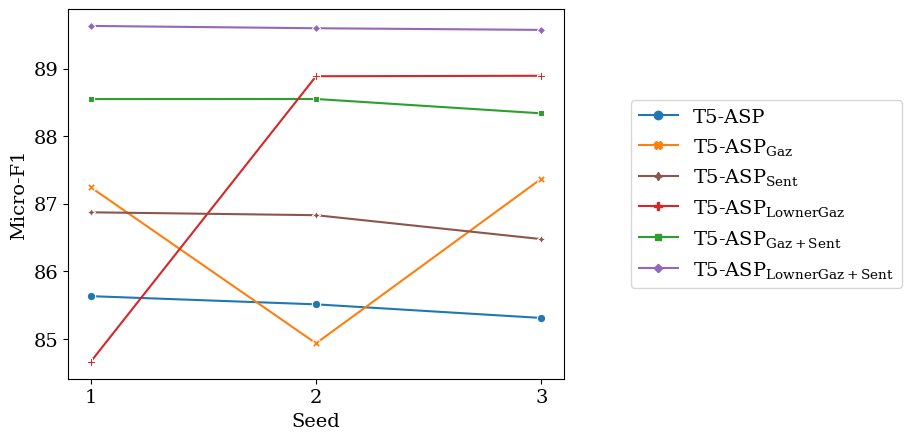

In [77]:
import seaborn as sns
from evaluations.utils import MODEL_ORDER, PLOT_MODEL_NAMES

sns.lineplot(t5_f1_seed_metrics, x="seed", y="f1", hue="model", style="model", dashes=False, markers=True)
handles, labels = plt.gca().get_legend_handles_labels()
order = [label_idx for _, label_idx in sorted([(MODEL_ORDER[label], idx) for idx, label in enumerate(labels)])]
plt.legend([handles[idx] for idx in order],
           [PLOT_MODEL_NAMES[labels[idx]] for idx in order],
           bbox_to_anchor=(1.7, 0.5),
           loc=7)
plt.ylabel("Micro-F1")
plt.xlabel("Seed")
LATEX_THESIS_PATH = "/home/loebbert/OneDrive/Studium/Master/Masterarbeit/Thesis"
plt.savefig(os.path.join(LATEX_THESIS_PATH, "drawings", "01_performance",
                         "t5_f1_per_seed.png"),
            dpi=200)


## Hypothesis 4-6 -- LM Plot / FacetGrid

In [12]:
import pandas as pd


combined_df = pd.read_pickle(
    os.path.join(thesis_path, "evaluations", "metrics",
                 "01_performance_combined_df.pkl.tar.gz")).reset_index()
t5_combined_df = combined_df[combined_df["model"]=="t5_asp_lownergaz_sent"]
t5_combined_df["target bin"] = t5_combined_df["targets"].apply(lambda x: x if x<=2 else 3)

/tmp/ipykernel_14390/3476962260.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t5_combined_df["target bin"] = t5_combined_df["targets"].apply(lambda x: x if x<=2 else 3)


/home/loebbert/miniconda3/envs/haystack/lib/python3.10/site-packages/seaborn/axisgrid.py:1609: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  func(x=x, y=y, **kwargs)
/home/loebbert/miniconda3/envs/haystack/lib/python3.10/site-packages/seaborn/axisgrid.py:1609: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  func(x=x, y=y, **kwargs)
/home/loebbert/miniconda3/envs/haystack/lib/python3.10/site-packages/seaborn/axisgrid.py:1609: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  func(x=x, y=y, **kwargs)
/home/loebbert/miniconda3/envs/haystack/lib/python3.10/site-packages/seaborn/axisgrid.py:1609: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  func(x=x, y=y, **kwargs)
/home/loebbe

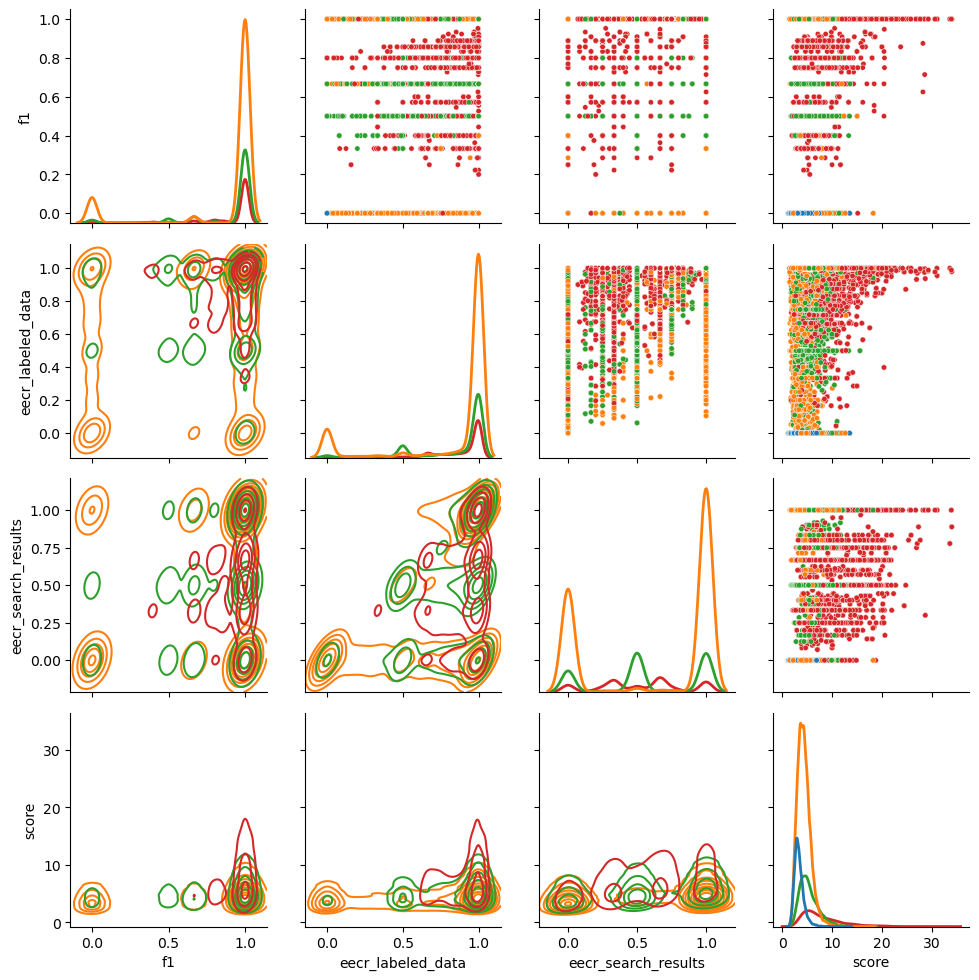

In [13]:
import seaborn as sns

g = sns.PairGrid(t5_combined_df[[
    "target bin", "f1", "eecr_labeled_data", "eecr_search_results", "score"
]],
                 hue="target bin",
                 diag_sharey=False,
                 palette="tab10")
g.map_upper(sns.scatterplot, s=15)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=2)

In [14]:
import matplotlib.pyplot as plt
g.add_legend()
LATEX_THESIS_PATH = "/home/loebbert/OneDrive/Studium/Master/Masterarbeit/Thesis"
g.savefig(os.path.join(LATEX_THESIS_PATH, "drawings", "01_performance",
                         "t5_asp_lownergaz_sent_performance.png"),
            dpi=200)